In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.datasets import CIFAR10
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import numpy as np

In [2]:
CHECKPOINT = '/Users/gauneg/Projects/graphs/model_checkpoint/autoenc_models'
DATASET_PATH = '/Users/gauneg/Projects/graphs/datasets/cifar10'

In [3]:
# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=transform, download=True)

train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class Encoder(nn.Module):
    def __init__(self, num_input_channels:int, base_channel_size:int, latent_dim: int, act_fn:object = nn.GELU) -> None:
        super().__init__()
        c_hid = base_channel_size
        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1, stride=2),
            act_fn(),
            nn.Flatten(),
            nn.Linear(2 * 2 * 2 * c_hid, latent_dim)

            # 2 * 16 * 32
        )

    def forward(self, x):
        return self.net(x)

In [5]:
class Decoder(nn.Module):
    def __init__(self, num_input_channels: int, base_channel_size:int, latent_dim: int, act_fn:object=nn.GELU) -> None:
        super().__init__()
        c_hid = base_channel_size
        self.linear = nn.Sequential(nn.Linear(latent_dim, 2 * 16 * c_hid), act_fn())
        self.net = nn.Sequential(
            nn.ConvTranspose2d(
                2 * c_hid, 2 * c_hid, kernel_size=3, output_padding=1, padding=1, stride=2
            ),
            act_fn(),
            nn.Conv2d(2 * c_hid, 2 * c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(2 * c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2), 
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),
            nn.ConvTranspose2d(
                c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2
            ),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x


In [6]:
class Autoencoder(nn.Module):

    def __init__(self, 
                 base_channel_size, 
                 latent_dim, 
                 encoder_class: object = Encoder, 
                 decoder_class: object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 32,
                 height: int = 32):
        super().__init__()
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)
        self.width = width
        self.height = height

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

encoder = Encoder(3, 32, 64)
decoder = Decoder(3, 32, 64)

In [7]:
latent_dim = 64  #[64, 128, 256, 384]
autoencoder = Autoencoder(base_channel_size=32, latent_dim=latent_dim)

optimizer = optim.Adam(params=autoencoder.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=20, min_lr=5e-5)




def train_epoch(model:nn.Module, 
          epoch_num: int, 
          optimizer: optim.Adam, 
          scheduler: optim.lr_scheduler.ReduceLROnPlateau, 
          loss_fn=F.mse_loss, 
          t_load: data.DataLoader=train_loader):
    model.train()
    train_epoch_loss = 0.0
    total_instace = 0
    print('start train')
    for batch in tqdm(t_load, desc=f"Training Epoch: {epoch_num}"):
        X, _ =   batch
        X_hat = model(X)
        loss = loss_fn(X, X_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_epoch_loss += loss.item()
        total_instace += batch.shape[0]
        print('batch')

    fin_log_string = f"Average loss = {train_epoch_loss/total_instace}"
    return model, fin_log_string

    

In [75]:
x_hat = decoder(x_h1)

In [76]:
term = x_hat.detach()
x = term.permute(0, 2, 3, 1).numpy()

In [85]:
# plt.imshow(x[4])

x.flatten().min(), x.flatten().max(), x.flatten().mean(), x.flatten().std()





(-0.20013739, 0.08959201, -0.019876657, 0.110027224)

# Encoder End
c_hid = 32

Conv2D() -> (64, 64, 2, 2)

Flatten()-> (64, 256)

Linear ? -> (64, 32 * 2 * 2 * 2)

# Decoder Beginning 


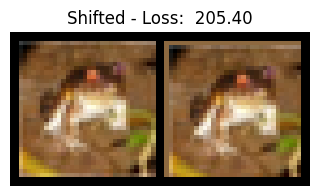

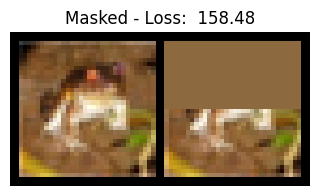

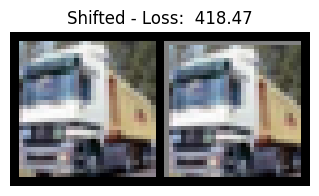

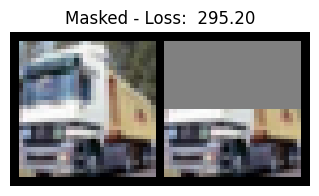

In [73]:
def compare_imgs(img1, img2, title_prefix=""):
    loss = F.mse_loss(img1, img2, reduction="sum")
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4, 2))
    plt.title(f'{title_prefix} Loss: {loss.item(): 4.2f}')
    plt.imshow(grid)
    plt.axis("off")
    plt.show()


for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    # mean across all channels 
    img_mean = img.mean(dim=[1,2], keepdims=True)

    # shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:, :1, :] = img_mean
    img_shifted[:, :, :1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")
    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:, : img_masked.shape[1] // 2, :] = img_mean
    compare_imgs(img, img_masked, "Masked -")




This shows the problem with MSE, almost identical images created by shifting pixel by 1 results in a higher loss than the loss when half of the image is blurred.

In [ ]:
class ReconstructCallback:
    def __init__(self) -> None:
        pass